In [ ]:
#!pip install texthero nltk -q

In [13]:
#!pip install jupyterlab "ipywidgets==7.0" -q

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#!conda install -y -c conda-forge nodejs

In [ ]:
# JupyterLab renderer support
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [ ]:
# OPTIONAL: Jupyter widgets extension
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [ ]:
#!conda install -y -c conda-forge pyldavis

### MODELAGEM DE TÓPICOS DE POSTAGENS DO LINKEDIN

##### IMPORT LIBS

In [44]:
import nltk
from nltk.stem.porter import *
nltk.download('stopwords')

import pandas as pd
import texthero as hero
import plotly.express as px
from texthero import preprocessing
pd.set_option('display.max_colwidth', None)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

import numpy as np
np.random.seed(2018)

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('once')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/altieris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
nltk_stopwords = nltk.corpus.stopwords.words('portuguese')

words_to_remove = ['everis','everisbrasil','everistalks','dutra','fabiola','zannier','weslley','cinq','cinqagoraedextra','lnkd','in','ja','bit','ly','hamsi',
                  'beeveris','invillia','midi','accntu','gozup','vemprazupremoto','chazzsaopaulo','smartworking','paulo','everisdx','ricardo','nttdata','gpnc'
                   ,'bill','coutinho','everisnamidia','zupopentalks','zupinsights','devcamp','dextra']

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



---

#### PRÉ PROCESSAMENTO

In [3]:
pdf = pd.read_csv("../datalake/raw/companies_data.csv")

In [4]:
pdf.shape

(1185, 10)

In [5]:
pdf.head()

,id,company,post_title,post_date,post_text,post_likes,post_comments,post_video_views,post_hashtags,origin
0,0,everis,NaN,2020-10-01,"'Em parceria com o #MITSloanReviewBrasil, realizamos hoje um Round Table com especialistas em #InteligênciaArtificial da América Latina, para debater sobre os principais impactos desta tecnologia no Brasil. Agradecemos a todos que participaram do evento online e também a presença de todos os speakers, Evandro Armelin, head de data & analytics da everis Brasil; Lluis Quiles Ardila, diretor de data science da everis Brasil; Sara Álvarez, diretora de inovação da MIT Technology Review; Renato Vieira, gerente de arquitetura e inovação na BR Distribuidora; Washington Vital, head de data analytics na SulAmérica e Fabricio Bindi, diretor de customer insights e inteligência artificial da Vivo. Você pode conferir o estudo completo, acessando https://lnkd.in/dq45j2R #everis #everisBrasil #EstudioIA'",17,1,0,"#MITSloanReviewBrasil,, #InteligênciaArtificial, #everis, #everisBrasil, #EstudioIA'",linkedin
1,1,everis,NaN,2020-10-01,"'Neste #webinar, especialistas da #everisBrasil falarão sobre as estratégias de Qualidade e como elas poderão melhorar a implementação do SRE. Inscreva-se: https://lnkd.in/g6hrP5P #everis #ITServices'",14,0,0,"#webinar,, #everisBrasil, #everis, #ITServices'",linkedin
2,2,everis,NaN,2020-10-01,"'Apresentamos o painel “2020: Visão dos diferentes elos da cadeia de saúde sobre qual foi a tecnologia mais alavancada pelas mudanças recentes do cenário do setor” na da 6ª edição do Healthcare Innovation Show (HIS), com Alejandro Morán Marco, Head Global de Health da everis. Agradecemos a todos que participaram. Veja como foi! #NTTDATA #everisBrasil #HIS'",20,1,0,"#NTTDATA, #everisBrasil, #HIS'",linkedin
3,3,everis,NaN,2020-09-30,"'Neste #webinar, especialistas da #everisBrasil falarão sobre as estratégias de Qualidade e como elas poderão melhorar a implementação do SRE. Inscreva-se: https://lnkd.in/g6hrP5P #everis #ITServices'",35,0,0,"#webinar,, #everisBrasil, #everis, #ITServices'",linkedin
4,4,everis,NaN,2020-09-30,"'No episódio de hoje, da série #WakeUp, Adam aprendeu que priorização e automação inteligente, economizam tempo e também aumentam a produtividade. Acesse o vídeo e veja como estamos planejando o futuro!https://lnkd.in/gNP-iuC #everis #everisBrasil #NTTDATA #everisWakeUp'",3,0,0,"#WakeUp,, #everis, #everisBrasil, #NTTDATA, #everisWakeUp'",linkedin


In [6]:
posts = pdf[['id','post_text']]

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
posts.head()

,id,post_text
0,0,"'Em parceria com o #MITSloanReviewBrasil, realizamos hoje um Round Table com especialistas em #InteligênciaArtificial da América Latina, para debater sobre os principais impactos desta tecnologia no Brasil. Agradecemos a todos que participaram do evento online e também a presença de todos os speakers, Evandro Armelin, head de data & analytics da everis Brasil; Lluis Quiles Ardila, diretor de data science da everis Brasil; Sara Álvarez, diretora de inovação da MIT Technology Review; Renato Vieira, gerente de arquitetura e inovação na BR Distribuidora; Washington Vital, head de data analytics na SulAmérica e Fabricio Bindi, diretor de customer insights e inteligência artificial da Vivo. Você pode conferir o estudo completo, acessando https://lnkd.in/dq45j2R #everis #everisBrasil #EstudioIA'"
1,1,"'Neste #webinar, especialistas da #everisBrasil falarão sobre as estratégias de Qualidade e como elas poderão melhorar a implementação do SRE. Inscreva-se: https://lnkd.in/g6hrP5P #everis #ITServices'"
2,2,"'Apresentamos o painel “2020: Visão dos diferentes elos da cadeia de saúde sobre qual foi a tecnologia mais alavancada pelas mudanças recentes do cenário do setor” na da 6ª edição do Healthcare Innovation Show (HIS), com Alejandro Morán Marco, Head Global de Health da everis. Agradecemos a todos que participaram. Veja como foi! #NTTDATA #everisBrasil #HIS'"
3,3,"'Neste #webinar, especialistas da #everisBrasil falarão sobre as estratégias de Qualidade e como elas poderão melhorar a implementação do SRE. Inscreva-se: https://lnkd.in/g6hrP5P #everis #ITServices'"
4,4,"'No episódio de hoje, da série #WakeUp, Adam aprendeu que priorização e automação inteligente, economizam tempo e também aumentam a produtividade. Acesse o vídeo e veja como estamos planejando o futuro!https://lnkd.in/gNP-iuC #everis #everisBrasil #NTTDATA #everisWakeUp'"


In [48]:
#create a custom cleaning pipeline
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_brackets
                   , preprocessing.remove_urls
                   , preprocessing.remove_square_brackets
                   , preprocessing.remove_curly_brackets
                   , preprocessing.remove_angle_brackets
                   , preprocessing.remove_html_tags
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                    ]

#pass the custom_pipeline to the pipeline argument
posts.loc[:,'post_text_cleansed'] = hero.clean(posts['post_text'], pipeline = custom_pipeline)

posts.loc[:,'post_text_cleansed'] = hero.remove_digits(posts['post_text_cleansed'], only_blocks=False)

#Call remove_stopwords and pass the custom_stopwords list
posts.loc[:,'post_text_cleansed']  = hero.remove_stopwords(posts['post_text_cleansed'], nltk_stopwords + words_to_remove)

In [49]:
tw = hero.visualization.top_words(posts['post_text_cleansed']).head(10)
fig = px.bar(tw)
fig.show()
tw.head()

sobre      369
voce       317
digital    291
nao        229
brasil     222
Name: post_text_cleansed, dtype: int64

In [50]:
tw = hero.visualization.top_words(posts['post_text_cleansed']).tail(10)
fig = px.bar(tw)
fig.show()
tw.head()

resultar        1
aproveitamos    1
burnout         1
interna         1
aguardam        1
Name: post_text_cleansed, dtype: int64

In [51]:
posts.head(5)

,id,post_text,post_text_cleansed
0,0,"'Em parceria com o #MITSloanReviewBrasil, realizamos hoje um Round Table com especialistas em #InteligênciaArtificial da América Latina, para debater sobre os principais impactos desta tecnologia no Brasil. Agradecemos a todos que participaram do evento online e também a presença de todos os speakers, Evandro Armelin, head de data & analytics da everis Brasil; Lluis Quiles Ardila, diretor de data science da everis Brasil; Sara Álvarez, diretora de inovação da MIT Technology Review; Renato Vieira, gerente de arquitetura e inovação na BR Distribuidora; Washington Vital, head de data analytics na SulAmérica e Fabricio Bindi, diretor de customer insights e inteligência artificial da Vivo. Você pode conferir o estudo completo, acessando https://lnkd.in/dq45j2R #everis #everisBrasil #EstudioIA'",parceria mitsloanreviewbrasil realizamos hoje round table especialistas inteligenciaartificial america latina debater sobre principais impactos desta tecnologia brasil agradecemos todos participaram evento online tambem presenca todos speakers evandro armelin head data analytics brasil lluis quiles ardila diretor data science brasil sara alvarez diretora inovacao mit technology review renato vieira gerente arquitetura inovacao br distribuidora washington vital head data analytics sulamerica fabricio bindi diretor customer insights inteligencia artificial vivo voce pode conferir estudo completo acessando dq j r estudioia
1,1,"'Neste #webinar, especialistas da #everisBrasil falarão sobre as estratégias de Qualidade e como elas poderão melhorar a implementação do SRE. Inscreva-se: https://lnkd.in/g6hrP5P #everis #ITServices'",neste webinar especialistas falarao sobre estrategias qualidade poderao melhorar implementacao sre inscreva g hrp p itservices
2,2,"'Apresentamos o painel “2020: Visão dos diferentes elos da cadeia de saúde sobre qual foi a tecnologia mais alavancada pelas mudanças recentes do cenário do setor” na da 6ª edição do Healthcare Innovation Show (HIS), com Alejandro Morán Marco, Head Global de Health da everis. Agradecemos a todos que participaram. Veja como foi! #NTTDATA #everisBrasil #HIS'","apresentamos painel "" visao diferentes elos cadeia saude sobre tecnologia alavancada mudancas recentes cenario setor"" edicao healthcare innovation show his alejandro moran marco head global health agradecemos todos participaram veja his"
3,3,"'Neste #webinar, especialistas da #everisBrasil falarão sobre as estratégias de Qualidade e como elas poderão melhorar a implementação do SRE. Inscreva-se: https://lnkd.in/g6hrP5P #everis #ITServices'",neste webinar especialistas falarao sobre estrategias qualidade poderao melhorar implementacao sre inscreva g hrp p itservices
4,4,"'No episódio de hoje, da série #WakeUp, Adam aprendeu que priorização e automação inteligente, economizam tempo e também aumentam a produtividade. Acesse o vídeo e veja como estamos planejando o futuro!https://lnkd.in/gNP-iuC #everis #everisBrasil #NTTDATA #everisWakeUp'",episodio hoje serie wakeup adam aprendeu priorizacao automacao inteligente economizam tempo tambem aumentam produtividade acesse video veja planejando futuro gnp iuc everiswakeup


--- 

##### FEATURE ENGINEERING

In [52]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [53]:
processed_docs = posts['post_text_cleansed'].map(preprocess)
processed_docs[:10]

0    [parceria, realizamos, hoje, round, table, especialistas, america, latina, debater, sobre, principais, impactos, desta, tecnologia, brasil, agradecemos, todos, participaram, evento, online, tambem, presenca, todos, speakers, evandro, armelin, head, data, analytics, brasil, lluis, quiles, ardila, diretor, data, science, brasil, sara, alvarez, diretora, inovacao, technology, review, renato, vieira, gerente, arquitetura, inovacao, distribuidora, washington, vital, head, data, analytics, sulamerica, fabricio, bindi, diretor, customer, insights, inteligencia, artificial, vivo, voce, pode, conferir, estudo, completo, acessando, estudioia]
1                                                                                                                                                                                                                                                                                                                                                                 

In [54]:
id2word = gensim.corpora.Dictionary(processed_docs)

# less than 15 documents (absolute number) or
# more than 0.5 (50%) documents (fraction of total corpus size, not absolute number).
# after the above two steps, keep only the first 100000 most frequent tokens.

id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

In [55]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('america', 1),
  ('analytics', 2),
  ('artificial', 1),
  ('brasil', 3),
  ('completo', 1),
  ('data', 3),
  ('diretor', 2),
  ('diretora', 1),
  ('especialistas', 1),
  ('estudo', 1),
  ('evento', 1),
  ('gerente', 1),
  ('head', 2),
  ('hoje', 1),
  ('impactos', 1),
  ('inovacao', 2),
  ('insights', 1),
  ('inteligencia', 1),
  ('latina', 1),
  ('online', 1),
  ('parceria', 1),
  ('pode', 1),
  ('presenca', 1),
  ('principais', 1),
  ('renato', 1),
  ('science', 1),
  ('sobre', 1),
  ('tambem', 1),
  ('tecnologia', 1),
  ('todos', 2),
  ('vivo', 1),
  ('voce', 1)]]

In [56]:
id2word[0]

'america'

In [57]:
doc_430 = corpus[430]
for i in range(len(doc_430)):
    print("Word {} (\"{}\") appears {} time.".format(doc_430[i][0], id2word[doc_430[i][0]], doc_430[i][1]))

Word 3 ("brasil") appears 1 time.
Word 33 ("inscreva") appears 1 time.
Word 67 ("conheca") appears 1 time.
Word 84 ("completa") appears 1 time.
Word 245 ("conceito") appears 1 time.
Word 252 ("clientes") appears 1 time.
Word 287 ("necessidades") appears 1 time.
Word 381 ("unica") appears 1 time.


In [58]:
# TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

---

##### MODEL TRAINING

In [59]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=8, id2word=id2word, passes=10, workers=4, chunksize=100,random_state=42)

In [60]:
for idx, topic in lda_model.print_topics():
    print('Topic: {} Formula: {}'.format(idx, lda_model.print_topic(idx, 10)))
    print('---')

Topic: 0 Formula: 0.033*"open" + 0.023*"youtube" + 0.022*"produto" + 0.021*"source" + 0.018*"nesse" + 0.018*"ainda" + 0.017*"tudo" + 0.015*"opensource" + 0.015*"mulheres" + 0.015*"abertas"
---
Topic: 1 Formula: 0.018*"voce" + 0.017*"link" + 0.014*"http" + 0.013*"vemprazup" + 0.012*"live" + 0.012*"evento" + 0.012*"aqui" + 0.011*"gente" + 0.011*"java" + 0.011*"desenvolvedor"
---
Topic: 2 Formula: 0.026*"blog" + 0.017*"dados" + 0.015*"outros" + 0.014*"digital" + 0.014*"podcast" + 0.014*"resultados" + 0.014*"conheca" + 0.013*"artigo" + 0.013*"texto" + 0.012*"spotify"
---
Topic: 3 Formula: 0.029*"codigo" + 0.021*"pessoas" + 0.018*"acesse" + 0.017*"parte" + 0.016*"weareciandt" + 0.016*"imagem" + 0.016*"conhece" + 0.016*"pracegover" + 0.015*"carreira" + 0.015*"ciandt"
---
Topic: 4 Formula: 0.016*"futureofwork" + 0.014*"trabalho" + 0.013*"mundo" + 0.013*"engagedbypeople" + 0.012*"instation" + 0.012*"engagedbydata" + 0.012*"innovation" + 0.012*"with" + 0.010*"carreiras" + 0.010*"oportunidades"


In [61]:
doc_lda = lda_model[corpus_tfidf]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(doc_lda))  # a measure of how good the model is. lower the better.


Perplexity:  -9.768452920577031


In [62]:

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3758072817156895


In [63]:
print(lda_model)

LdaModel(num_terms=444, num_topics=8, decay=0.5, chunksize=100)


In [64]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, id2word)
# vis

---

### How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.


In [65]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, passes=10, workers=4, chunksize=100,random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [93]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=processed_docs, start=2, limit=20, step=1)

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [96]:
coherence_values

[0.3502769824789597,
 0.33381719832019763,
 0.3445305475997429,
 0.37426211819859717,
 0.39707681165697206,
 0.4221404639245487,
 0.3520168939755769,
 0.3626967694899451,
 0.3686601636204633,
 0.37830534314621106,
 0.34995674354957096,
 0.35553704615335857,
 0.3364533921858948,
 0.3745622610772178,
 0.37380940331147716,
 0.32577097876895417,
 0.31198033539110764,
 0.3435785210645037]

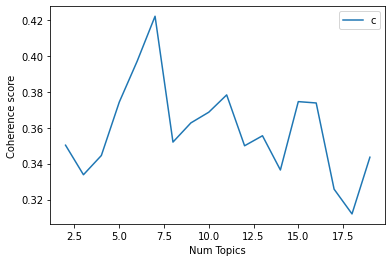

In [97]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [98]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3503
Num Topics = 3  has Coherence Value of 0.3338
Num Topics = 4  has Coherence Value of 0.3445
Num Topics = 5  has Coherence Value of 0.3743
Num Topics = 6  has Coherence Value of 0.3971
Num Topics = 7  has Coherence Value of 0.4221
Num Topics = 8  has Coherence Value of 0.352
Num Topics = 9  has Coherence Value of 0.3627
Num Topics = 10  has Coherence Value of 0.3687
Num Topics = 11  has Coherence Value of 0.3783
Num Topics = 12  has Coherence Value of 0.35
Num Topics = 13  has Coherence Value of 0.3555
Num Topics = 14  has Coherence Value of 0.3365
Num Topics = 15  has Coherence Value of 0.3746
Num Topics = 16  has Coherence Value of 0.3738
Num Topics = 17  has Coherence Value of 0.3258
Num Topics = 18  has Coherence Value of 0.312
Num Topics = 19  has Coherence Value of 0.3436


In [100]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=True)
optimal_model.print_topics(num_words=30)

[(0,
  '0.071*"blog" + 0.036*"mulheres" + 0.034*"lideranca" + 0.029*"texto" + 0.029*"leia" + 0.022*"manager" + 0.022*"saiba" + 0.020*"artigo" + 0.015*"tempos" + 0.014*"podemos" + 0.013*"solucoes" + 0.013*"operations" + 0.012*"melhorar" + 0.012*"importante" + 0.012*"virtual" + 0.012*"tema" + 0.011*"produto" + 0.010*"tecnologia" + 0.009*"desafio" + 0.009*"agora" + 0.009*"integra" + 0.009*"plataforma" + 0.008*"strategy" + 0.008*"tech" + 0.008*"colaboracao" + 0.008*"cesar" + 0.008*"automacao" + 0.008*"operacoes" + 0.008*"diversas" + 0.007*"experiencia"'),
 (1,
  '0.016*"voce" + 0.011*"link" + 0.011*"gente" + 0.011*"hoje" + 0.011*"sobre" + 0.010*"aqui" + 0.009*"live" + 0.009*"ainda" + 0.009*"tudo" + 0.009*"programa" + 0.009*"http" + 0.009*"vamos" + 0.008*"vemprazup" + 0.008*"open" + 0.008*"inscreva" + 0.008*"fazer" + 0.008*"evento" + 0.008*"confira" + 0.008*"vagas" + 0.007*"quer" + 0.007*"agora" + 0.007*"nesse" + 0.007*"todos" + 0.007*"venha" + 0.007*"tecnologia" + 0.006*"mundo" + 0.006*"lu

---

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [101]:
data = posts['post_text_cleansed'].values

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_tfidf, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [102]:
df_dominant_topic[(df_dominant_topic.Dominant_Topic == 0)].head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
49,49,0.0,0.7600,"blog, mulheres, lideranca, texto, leia, manager, saiba, artigo, tempos, podemos",privacyops aumenta habilidade organizacao atender diversas regulamentacoes privacidade auxilio alta tecnologia leia artigo saiba g wq pk strategy tech everisd
71,71,0.0,0.7518,"blog, mulheres, lideranca, texto, leia, manager, saiba, artigo, tempos, podemos",automacao virtual finalmente abrange ampla gama tecnologias diferentes graus sofisticacao vao desde solucoes negocios ate automacao cognitiva gxkpg f hybridoperations transformacaodigital
72,72,0.0,0.4979,"blog, mulheres, lideranca, texto, leia, manager, saiba, artigo, tempos, podemos",nomeada global partner of the year outsystems reconhecendo sucesso trazer plataforma outsystems novas geografias industrias eduardo romano presente evento onde premio entregue s
89,89,0.0,0.1429,"blog, mulheres, lideranca, texto, leia, manager, saiba, artigo, tempos, podemos",
98,98,0.0,0.7518,"blog, mulheres, lideranca, texto, leia, manager, saiba, artigo, tempos, podemos",automacao virtual finalmente abrange ampla gama tecnologias diferentes graus sofisticacao vao desde solucoes negocios ate automacao cognitiva gxkpg f hybridoperations transformacaodigital


In [103]:
df_dominant_topic[(df_dominant_topic.Dominant_Topic == 1)].head(5)

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
4,4,1.0,0.7821,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",episodio hoje serie wakeup adam aprendeu priorizacao automacao inteligente economizam tempo tambem aumentam produtividade acesse video veja planejando futuro gnp iuc everiswakeup
6,6,1.0,0.7950,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",startup pode ser proxima representar brasil buscamos projetos areas banking telecom utilities energy retail consumergoods trabalhando mudar setores conheca edicao agora queremos conhecer voce inscreva gez hic openinnovation oic
12,12,1.0,0.5683,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",parceria mitsloanreviewbrasil convidamos especialistas inteligenciaartificial debater sobre principais impactos ia brasil encontro sera dia outubro h inscreva http everismit l estudioia
15,15,1.0,0.3850,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",parceria mitsloanreviewbrasil convidamos especialistas inteligenciaartificial america latina debater sobre principais impactos desta tecnologia brasil evento online sera dia outubro h inscreva http everismit l estudioia
23,23,1.0,0.5277,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",buscarmos startups projeto setores banking telecom utilities energy retail consumergoods momento fazer negocio inscreva edicao \xa open\xa innovation\xa contest >[?]conheca sobre competicao mundial gez hic openinnovation oic


In [104]:
df_dominant_topic[(df_dominant_topic.Dominant_Topic == 2)].head(5)

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1,1,2.0,0.7772,"growth, digital, dados, with, global, innovation, power, infinite, more, framework",neste webinar especialistas falarao sobre estrategias qualidade poderao melhorar implementacao sre inscreva g hrp p itservices
3,3,2.0,0.7772,"growth, digital, dados, with, global, innovation, power, infinite, more, framework",neste webinar especialistas falarao sobre estrategias qualidade poderao melhorar implementacao sre inscreva g hrp p itservices
5,5,2.0,0.7958,"growth, digital, dados, with, global, innovation, power, infinite, more, framework",podcast interessante especialistas sobre uso dados desenhar melhor experiencia cliente spotify spoti fi hkweeo google fjzqfbapple apple co ivqjl deezer hnmodjtunein rkuuj everistalkspodcast strategy tech
9,9,2.0,0.8085,"growth, digital, dados, with, global, innovation, power, infinite, more, framework",neste podcast abordamos importancia governanca dados pode fazer diferenca qualidade dados serao utilizados negocio tomada decisoes spotify spoti fi lzn abgoogle gjkzw eapple apple co hnoguldeezer gi hi tunein gsfui f everistalkspodcast strategy tech
13,13,2.0,0.7900,"growth, digital, dados, with, global, innovation, power, infinite, more, framework",neste webinar debatemos muda rotina diaria empresas lei geral protecao dados pessoais vigor fica papel dpo data protection officer conteudo disponivel acesse agora gsxwptw cybersecurity


### Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [105]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8236,"blog, mulheres, lideranca, texto, leia, manager, saiba, artigo, tempos, podemos",estimular mindset protagonismo traz tona poder escolha pessoas empresas constroi bases cada individuo crie propria jornada evolucao saiba sobre assunto artigo senior business partner manager joceline abe seixas people development strategist taliza weiss leia agora by
1,1.0,0.8620,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",pra fechar chave ouro edicao zup open talks convidada honra loiane groner business analysis senior manager citibank possui anos experiencia ti areas especializacao incluem java tecnologias sencha ext js angular desenvolvimento hibrido dispositivos moveis phonegap ionic apaixonada compartilhar conhecimento estara gente proxima quinta feira hrs falando sobre java spring pratica vejo la inscreva agora nesse webinar gratuito exclusivo clicando link xgqqtk
2,2.0,0.8351,"growth, digital, dados, with, global, innovation, power, infinite, more, framework","marcelo ficotto digital experience manager maximiliano marco luz director head of digital experience brazil apresentaram conceito ""liquid digital workplace trabalho remoto produtivo inclusivo"" setor bancario hoje transformacao digital home office ensinado nao importa onde trabalhamos possivel ser produtivo executar casa tarefas rotineiras usando tecnologia desafio aprendermos ser inclusivos simplificar tarefas diarias incluindo gerenciamento equipes strategy tech"
3,3.0,0.8529,"transformacao, empresas, digital, brasil, impacto, acesse, melhores, microsoft, pessoas, novo",digital conference promovera discussoes referente futuro transformacao digital tendencias novo cenario proximo dia julho h tema utilities impacto transformacao alem tecnologia sera abordado painel executivo silvio antunes head utilities brasil sera responsavel moderar discussao dario almeida gerente executivo arquitetura sistemas ccee igor ripoll vp utilities manufatura recursos naturais salesforce tarso andreo filho head salesforce brasil acesse inscreva vg everisdigitalconference
4,4.0,0.8783,"futureofwork, engagedbypeople, instation, engagedbydata, oportunidades, globalcommunity, trabalho, equipe, carreiras, vagas",diferentes tres palavras action capacidade adaptar desafios poder reagir tecnologia metodologia data move ensina faz melhorar sempre people conecta tudo inteligencia criatividade faz tao unicos conheca pouco sobre vaga dezenas outras ertpytj inovamos gamechangers startups unicornios cultura trabalho conectado instation forma exclusiva performar globalgrowthframework reskill continuo invilliaacademy beneficios unicos infinitepowers novo plano evolucao carreiras pei engagedbydata engagedbypeople bestmindsbestwhere vagas oportunidades carreiras globalcommunity infinitedigitalpower recrutamento ti java techtalents futureofwork


### Topic distribution across documents

In [106]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"diretor, brasil, inovacao, digital, data, desenvolvedor, design, negocio, estudo, inscricao",42.0,0.0354
1.0,2.0,"growth, digital, dados, with, global, innovation, power, infinite, more, framework",444.0,0.3747
2.0,5.0,"diretor, brasil, inovacao, digital, data, desenvolvedor, design, negocio, estudo, inscricao",162.0,0.1367
3.0,2.0,"growth, digital, dados, with, global, innovation, power, infinite, more, framework",169.0,0.1426
4.0,1.0,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",130.0,0.1097
...,...,...,...,...
1180.0,5.0,"diretor, brasil, inovacao, digital, data, desenvolvedor, design, negocio, estudo, inscricao",NaN,NaN
1181.0,1.0,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",NaN,NaN
1182.0,1.0,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",NaN,NaN
1183.0,1.0,"voce, link, gente, hoje, sobre, aqui, live, ainda, tudo, programa",NaN,NaN


---

#### MODEL VALIDATION

In [107]:
bow_doc_4310 = corpus[430]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], id2word[bow_doc_4310[i][0]], bow_doc_4310[i][1]))

Word 3 ("brasil") appears 1 time.
Word 33 ("inscreva") appears 1 time.
Word 67 ("conheca") appears 1 time.
Word 84 ("completa") appears 1 time.
Word 245 ("conceito") appears 1 time.
Word 252 ("clientes") appears 1 time.
Word 287 ("necessidades") appears 1 time.
Word 381 ("unica") appears 1 time.


/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [108]:
bow_doc_4310 = corpus_tfidf[430]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], id2word[bow_doc_4310[i][0]], bow_doc_4310[i][1]))

Word 3 ("brasil") appears 0.205256123265157 time.
Word 33 ("inscreva") appears 0.19617258717663566 time.
Word 67 ("conheca") appears 0.2686949915123457 time.
Word 84 ("completa") appears 0.39641131243492167 time.
Word 245 ("conceito") appears 0.4468016130272999 time.
Word 252 ("clientes") appears 0.3244703597914739 time.
Word 287 ("necessidades") appears 0.4534999922792871 time.
Word 381 ("unica") appears 0.4236417991984128 time.


In [109]:
for index, score in sorted(optimal_model[corpus_tfidf[430]], key=lambda tup: -1*tup[1]):
    print(f"\nTopic: {index} Score: {score}\t \nTopic: {optimal_model.print_topic(index, 10)}")


Topic: 2 Score: 0.6647346615791321	 
Topic: 0.020*"growth" + 0.018*"digital" + 0.017*"dados" + 0.017*"with" + 0.014*"global" + 0.013*"innovation" + 0.013*"power" + 0.013*"infinite" + 0.013*"more" + 0.012*"framework"

Topic: 4 Score: 0.14262409508228302	 
Topic: 0.022*"futureofwork" + 0.019*"engagedbypeople" + 0.018*"instation" + 0.018*"engagedbydata" + 0.016*"oportunidades" + 0.015*"globalcommunity" + 0.014*"trabalho" + 0.014*"equipe" + 0.013*"carreiras" + 0.013*"vagas"

Topic: 3 Score: 0.038576994091272354	 
Topic: 0.020*"transformacao" + 0.017*"empresas" + 0.016*"digital" + 0.014*"brasil" + 0.014*"impacto" + 0.013*"acesse" + 0.013*"melhores" + 0.012*"microsoft" + 0.012*"pessoas" + 0.012*"novo"

Topic: 5 Score: 0.038552381098270416	 
Topic: 0.016*"diretor" + 0.016*"brasil" + 0.015*"inovacao" + 0.015*"digital" + 0.013*"data" + 0.013*"desenvolvedor" + 0.012*"design" + 0.011*"negocio" + 0.011*"estudo" + 0.010*"inscricao"

Topic: 6 Score: 0.0385286845266819	 
Topic: 0.042*"mutant" + 0.02

### Teste com um documento novo

In [110]:
unseen_document = 'venha trabalhar na dextra '
bow_vector = id2word.doc2bow(preprocess(unseen_document))

for index, score in sorted(optimal_model[bow_vector], key=lambda tup: -1*tup[1]):
    print(f"\nTopic: {index} Score: {score}\t \nTopic: {optimal_model.print_topic(index, 10)}") 


Topic: 5 Score: 0.7136549353599548	 
Topic: 0.016*"diretor" + 0.016*"brasil" + 0.015*"inovacao" + 0.015*"digital" + 0.013*"data" + 0.013*"desenvolvedor" + 0.012*"design" + 0.011*"negocio" + 0.011*"estudo" + 0.010*"inscricao"

Topic: 1 Score: 0.047985874116420746	 
Topic: 0.016*"voce" + 0.011*"link" + 0.011*"gente" + 0.011*"hoje" + 0.011*"sobre" + 0.010*"aqui" + 0.009*"live" + 0.009*"ainda" + 0.009*"tudo" + 0.009*"programa"

Topic: 3 Score: 0.04778647422790527	 
Topic: 0.020*"transformacao" + 0.017*"empresas" + 0.016*"digital" + 0.014*"brasil" + 0.014*"impacto" + 0.013*"acesse" + 0.013*"melhores" + 0.012*"microsoft" + 0.012*"pessoas" + 0.012*"novo"

Topic: 4 Score: 0.04771022871136665	 
Topic: 0.022*"futureofwork" + 0.019*"engagedbypeople" + 0.018*"instation" + 0.018*"engagedbydata" + 0.016*"oportunidades" + 0.015*"globalcommunity" + 0.014*"trabalho" + 0.014*"equipe" + 0.013*"carreiras" + 0.013*"vagas"

Topic: 2 Score: 0.04762092977762222	 
Topic: 0.020*"growth" + 0.018*"digital" + 0.0

In [111]:
#!pip install pyLDAvis

In [112]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.090022 -0.036279       1        1  32.118733
5     -0.014347  0.135326       2        1  14.933638
3      0.010104  0.083493       3        1  14.281336
2     -0.107298  0.054238       4        1  12.821437
4     -0.158128 -0.124062       5        1  12.687496
6      0.139551 -0.049416       6        1   7.387592
0      0.040096 -0.063300       7        1   5.769768, topic_info=            Term       Freq      Total Category  logprob  loglift
410         blog  17.000000  17.000000  Default  30.0000  30.0000
443       mutant  13.000000  13.000000  Default  29.0000  29.0000
302         live  25.000000  25.000000  Default  28.0000  28.0000
367     mulheres   9.000000   9.000000  Default  27.0000  27.0000
382        texto  11.000000  11.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
28    tecnologia   2.394748  24.590086   Topic7  -4.5660   0.5235
64      strategy   1.935161  16.367662   Topic7  -4.7791   0.7174
66         agora   1.992908  18.136154   Topic7  -4.7497   0.6442
65          tech   1.897239  18.166305   Topic7  -4.7989   0.5934
59   experiencia   1.701300  15.937471   Topic7  -4.9079   0.6153

[332 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
280       1  0.922451          abertas
384       2  0.769342        accenture
384       4  0.153868        accenture
51        1  0.154934           acesse
51        2  0.051645           acesse
...     ...       ...              ...
122       5  0.178336            world
366       1  0.895898          youtube
441       1  0.877584  zupnohomeoffice
436       1  0.876865           zupper
437       1  0.942380          zuppers

[758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 3, 5, 7, 1])

/work/tools/anaconda3/envs/dna-brand-platform/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



IndexError: list index out of range

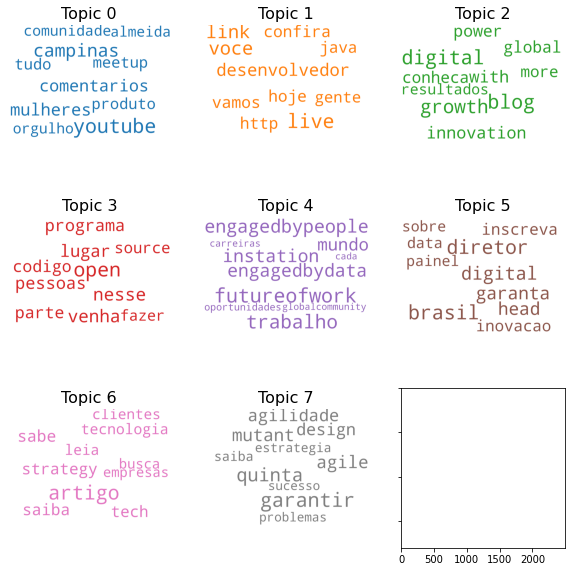

In [83]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=nltk_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=12, y=1.05)    
plt.show()

---

### PRÓXIMOS PASSOS

> 1. Identificar os tópicos (tipo,assunto,modelo)  
    * Identificar o número ideal de tópicos ( fine tunning )  
    * Categorizar o dataset utilizando os tópicos modelados  
2. Servir o dataset categorizado como input para um modelo supervisionado  
    * Avaliar os resultados do modelo supervisionado  

### REFERÊNCIAS

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/


https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0  
https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Beginner%20-%20NLP101.ipynb
https://texthero.org/docs/api/texthero.visualization.wordcloud.html#texthero.visualization.wordcloud  
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24  
https://radimrehurek.com/gensim/